In [18]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline
def load_jsons(data_path, file):
    """ helper function to load '.json' files (they're not proper jsons) """
    file_path = data_path + file
    with open(file_path) as jsons:
        lines = [json.loads(json_line) for json_line in jsons]
    return pd.DataFrame(lines)

### Data inladen 

    Load data for town called Ambridge
    data_path = './data/ambridge/'
    review_file = 'review.json'
    business_file = 'business.json'
    user_file = 'user.json'
    tip_file = 'tip.json'
    checkin_file = 'checkin.json'

    reviews = load_jsons(data_path, review_file)
    businesses = load_jsons(data_path, business_file)
    users = load_jsons(data_path, user_file)
    tips = load_jsons(data_path, tip_file)
    checkins = load_jsons(data_path, checkin_file)

In [9]:
# Loop over alle data 
for filename in os.listdir('data'):
    for file in os.listdir(f"data/{filename}"):
        pass

In [24]:
data_path = './data/ajax/'
review_file = 'review.json'
business_file = 'business.json'
user_file = 'user.json'
tip_file = 'tip.json'
checkin_file = 'checkin.json'

reviews = load_jsons(data_path, review_file)
businesses = load_jsons(data_path, business_file)
users = load_jsons(data_path, user_file)
tips = load_jsons(data_path, tip_file)
checkins = load_jsons(data_path, checkin_file)


Text(0.5, 1.0, 'reviews per user')

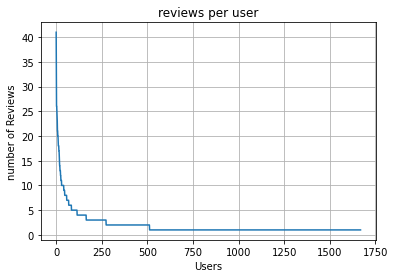

In [23]:
# Reviews per User plot (voor één gebied)

user = reviews.groupby("user_id")
stars = user['stars']
stars = stars.apply(len)

# Plot
fig, (ax1) = plt.subplots(ncols=1)
ax1.plot(list(stars.sort_values(ascending=False)))
ax1.grid(True)
ax1.set_xlabel("Users")
ax1.set_ylabel("number of Reviews")
ax1.set_title("reviews per user")